In [148]:
import boto3
import pandas

client = boto3.client('dynamodb')
items = []
page = True
query= """SELECT * FROM "Session-e3tq3jp6jjh4xjjpvydbqj64e4-dev" WHERE CONTAINS("name", '3-squats')"""

resp = client.execute_statement(Statement=query, Limit=1000)
items.extend(resp['Items'])
while 'LastEvaluatedKey' in resp:
  resp = client.execute_statement(Statement=query,Limit=1000,NextToken=resp["NextToken"])
  items.extend(resp['Items'])

def flatten(obj, key):
  if (len(obj) == 1):
    if 'S' in obj:
      return obj["S"]
    if 'N' in obj:
      return float(obj["N"])
    if 'L' in obj:
      for i in range(len(obj["L"])):
        obj["L"][i] = flatten(obj["L"][i],key) 
      obj = obj["L"]
  else:
    for k, value in obj.items(): 
  
        obj[k] = flatten(value, k)
  return obj


items = [flatten(items[i],'') for i in range(len(items))]

df = pandas.DataFrame(items[0])

df

,__typename,_lastChangedAt,linearAccerationTimestamp,createdAt,name,quaternionW,quaternionX,linearAccerationZ,quaternionY,linearAccerationY,quaternionZ,_version,linearAccerationX,updatedAt,owner,id,quaternionTimestamp
0,Session,1.672076e+12,1.672073e+09,2022-12-26T17:34:27.880Z,3-squats-2,0.956663,-0.271170,0.024203,-0.066982,-0.006839,-0.082315,1.0,0.015675,2022-12-26T17:34:27.880Z,43d1cc9a-eacd-4d09-8c12-7352818673de::jdavis,713dabad-42c7-412e-87cb-e523dd4cbc83,1.672073e+09
1,Session,1.672076e+12,1.672073e+09,2022-12-26T17:34:27.880Z,3-squats-2,0.956663,-0.271162,0.017366,-0.067006,-0.004418,-0.082322,1.0,0.017580,2022-12-26T17:34:27.880Z,43d1cc9a-eacd-4d09-8c12-7352818673de::jdavis,713dabad-42c7-412e-87cb-e523dd4cbc83,1.672073e+09
2,Session,1.672076e+12,1.672073e+09,2022-12-26T17:34:27.880Z,3-squats-2,0.956677,-0.271104,0.010964,-0.067040,-0.007945,-0.082326,1.0,0.021916,2022-12-26T17:34:27.880Z,43d1cc9a-eacd-4d09-8c12-7352818673de::jdavis,713dabad-42c7-412e-87cb-e523dd4cbc83,1.672073e+09
3,Session,1.672076e+12,1.672073e+09,2022-12-26T17:34:27.880Z,3-squats-2,0.956708,-0.270993,0.011325,-0.067014,-0.009604,-0.082346,1.0,0.018062,2022-12-26T17:34:27.880Z,43d1cc9a-eacd-4d09-8c12-7352818673de::jdavis,713dabad-42c7-412e-87cb-e523dd4cbc83,1.672073e+09
4,Session,1.672076e+12,1.672073e+09,2022-12-26T17:34:27.880Z,3-squats-2,0.999998,0.000937,-0.032713,-0.000165,-0.225997,-0.001566,1.0,-0.001304,2022-12-26T17:34:27.880Z,43d1cc9a-eacd-4d09-8c12-7352818673de::jdavis,713dabad-42c7-412e-87cb-e523dd4cbc83,1.672073e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,Session,1.672076e+12,1.672073e+09,2022-12-26T17:34:27.880Z,3-squats-2,0.965762,-0.256039,0.030427,-0.040738,-0.008176,-0.009413,1.0,0.019520,2022-12-26T17:34:27.880Z,43d1cc9a-eacd-4d09-8c12-7352818673de::jdavis,713dabad-42c7-412e-87cb-e523dd4cbc83,1.672073e+09
1310,Session,1.672076e+12,1.672073e+09,2022-12-26T17:34:27.880Z,3-squats-2,0.965807,-0.255847,0.043917,-0.040828,-0.005119,-0.009573,1.0,0.018777,2022-12-26T17:34:27.880Z,43d1cc9a-eacd-4d09-8c12-7352818673de::jdavis,713dabad-42c7-412e-87cb-e523dd4cbc83,1.672073e+09
1311,Session,1.672076e+12,1.672073e+09,2022-12-26T17:34:27.880Z,3-squats-2,0.965826,-0.255765,0.056535,-0.040863,-0.004301,-0.009697,1.0,0.019135,2022-12-26T17:34:27.880Z,43d1cc9a-eacd-4d09-8c12-7352818673de::jdavis,713dabad-42c7-412e-87cb-e523dd4cbc83,1.672073e+09
1312,Session,1.672076e+12,1.672073e+09,2022-12-26T17:34:27.880Z,3-squats-2,0.965794,-0.255878,0.063491,-0.040898,-0.006555,-0.009841,1.0,0.025829,2022-12-26T17:34:27.880Z,43d1cc9a-eacd-4d09-8c12-7352818673de::jdavis,713dabad-42c7-412e-87cb-e523dd4cbc83,1.672073e+09


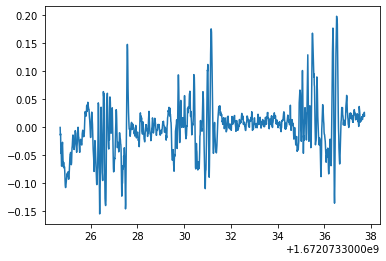

In [146]:
import matplotlib.pyplot as plt

plt.plot(df['linearAccerationTimestamp'][4::], df['linearAccerationX'][4::])